In [1]:
import re
import nltk
import pyspark 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col, sum, length, when, count, explode, udf, expr
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [2]:
spark = SparkSession.builder\
	.master("local").appName("Preprocessing").getOrCreate()

24/12/11 14:47:23 WARN Utils: Your hostname, hungnd-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/12/11 14:47:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/11 14:47:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("hdfs://localhost:9000/final/", header=True, inferSchema=True)
df.show()
df.printSchema()

+------+---------+---------------+--------------------+
|ItemID|Sentiment|SentimentSource|       SentimentText|
+------+---------+---------------+--------------------+
|     1|        0|   Sentiment140|                 ...|
|     2|        0|   Sentiment140|                 ...|
|     3|        1|   Sentiment140|              omg...|
|     4|        0|   Sentiment140|          .. Omga...|
|     5|        0|   Sentiment140|         i think ...|
|     6|        0|   Sentiment140|         or i jus...|
|     7|        1|   Sentiment140|       Juuuuuuuuu...|
|     8|        0|   Sentiment140|       Sunny Agai...|
|     9|        1|   Sentiment140|      handed in m...|
|    10|        1|   Sentiment140|      hmmmm.... i...|
|    11|        0|   Sentiment140|      I must thin...|
|    12|        1|   Sentiment140|      thanks to a...|
|    13|        0|   Sentiment140|      this weeken...|
|    14|        0|   Sentiment140|     jb isnt show...|
|    15|        0|   Sentiment140|     ok thats 

In [4]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 1578627
Number of columns: 4


In [5]:
# Check Null value
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
print("Null counts:")
null_counts.show()

# Remove Null value 
df = df.dropna()

# Remove duplicate
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")
df = df.dropDuplicates()


Null counts:


+------+---------+---------------+-------------+
|ItemID|Sentiment|SentimentSource|SentimentText|
+------+---------+---------------+-------------+
|     0|        0|              0|            0|
+------+---------+---------------+-------------+



Number of duplicate rows: 0


+---------------+-------+
|SentimentSource|  count|
+---------------+-------+
|   Sentiment140|1577278|
|         Kaggle|   1349|
+---------------+-------+



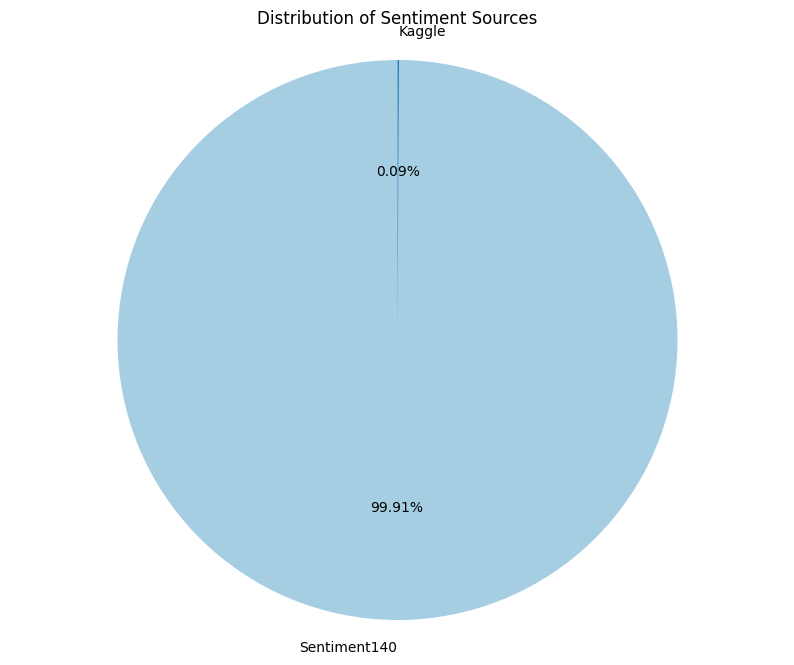

In [6]:
# Sentiment source
df.groupBy("SentimentSource").count().show()
sentiment_source_count = df.groupBy("SentimentSource").count().toPandas()

plt.figure(figsize=(10, 8))
plt.pie(
    sentiment_source_count["count"],
    labels=sentiment_source_count["SentimentSource"],
    autopct="%.2f%%",
    startangle=90,
    colors=plt.cm.Paired.colors,
)
plt.title("Distribution of Sentiment Sources")
plt.axis("equal")
plt.show()

+---------+------+-----------------+
|Sentiment| count|       percentage|
+---------+------+-----------------+
|        1|790185|50.05520620133825|
|        0|788442|49.94479379866175|
+---------+------+-----------------+



(-1.0999999999964865,
 1.0999999999797305,
 -1.099999999979835,
 1.0999999999990397)

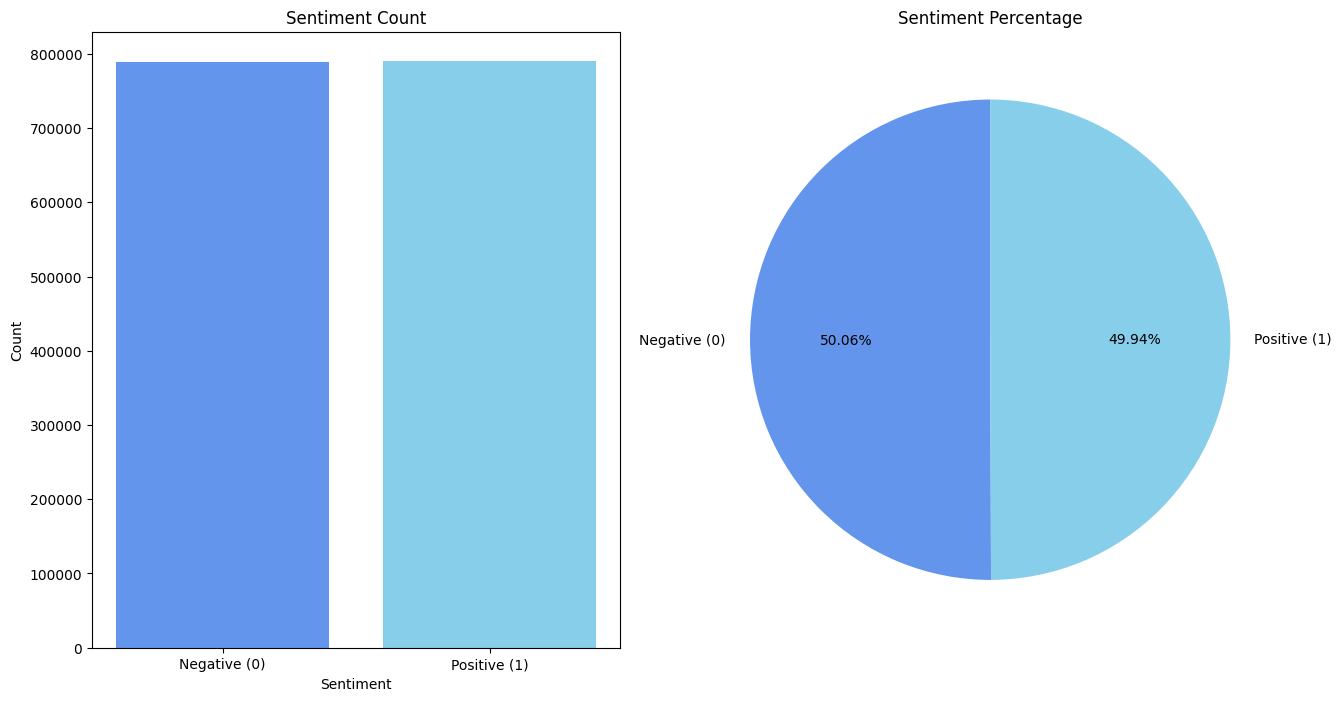

In [7]:
#Sentiment statistic
total_rows = df.count()
df.groupBy("Sentiment").count() \
    .withColumn("percentage", (col("count") / total_rows) * 100) \
    .show()

sentiment_stat = df.groupBy("Sentiment").count() \
    .withColumn("percentage", (col("count") / total_rows) * 100)

sentiment_stat_pd = sentiment_stat.toPandas()
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.bar(
    sentiment_stat_pd["Sentiment"], 
    sentiment_stat_pd["count"], 
    color=["skyblue", "cornflowerblue"]
)
plt.title("Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])

plt.subplot(1,2,2)
plt.pie(
    sentiment_stat_pd["percentage"], 
    labels=["Negative (0)", "Positive (1)"], 
    autopct="%.2f%%", 
    colors=["cornflowerblue", "skyblue" ],
    startangle=90
)
plt.title("Sentiment Percentage")
plt.axis("equal")

+-------+------------------+
|summary|       text_length|
+-------+------------------+
|  count|           1578627|
|   mean| 74.62733185229949|
| stddev|36.135526756445174|
|    min|                 6|
|    max|               374|
+-------+------------------+



Text(0.5, 0, 'Text Length')

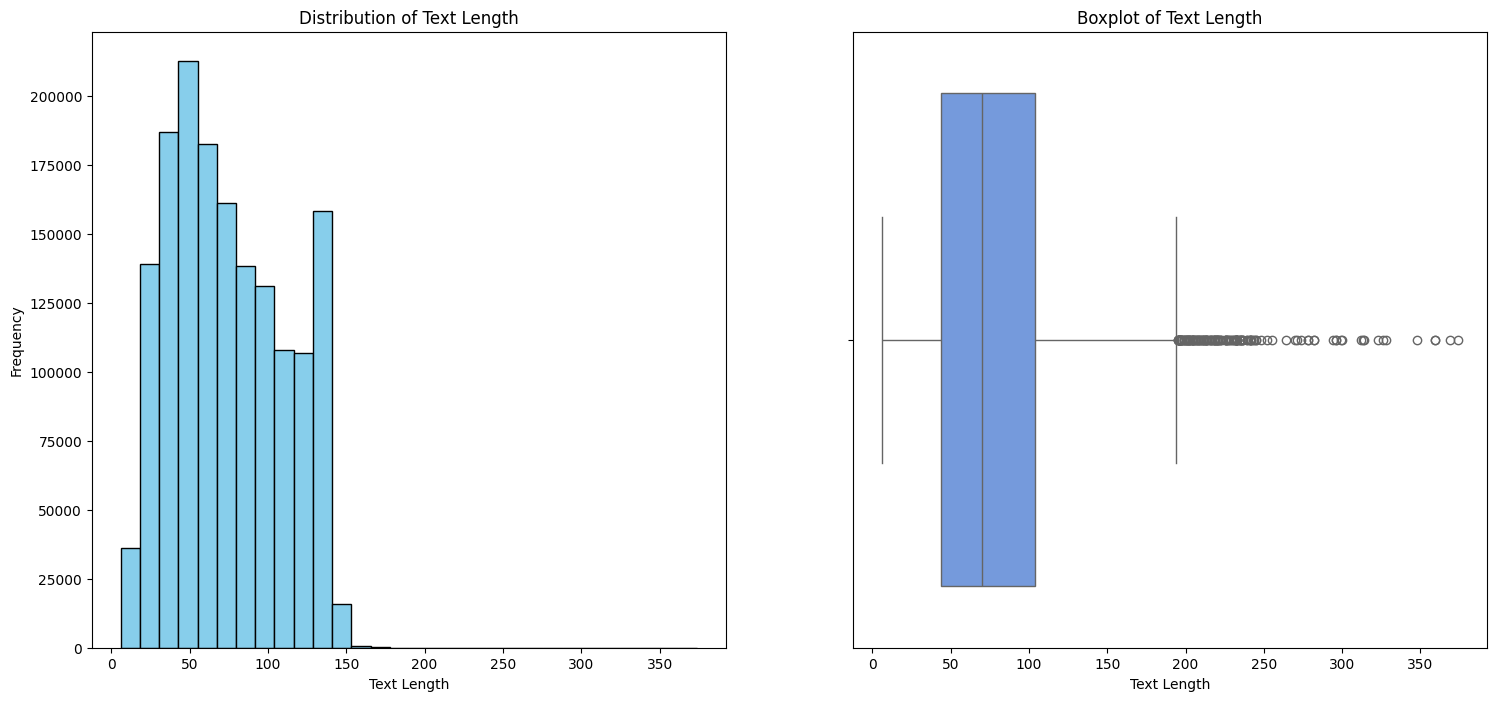

In [8]:
# Text length statistics:
df = df.withColumn("text_length", length("SentimentText"))
df.select("text_length").describe().show()

#Visualize
text_length_pd = df.select("text_length").toPandas()
plt.figure(figsize=(18, 8))

plt.subplot(1,2,1)
plt.hist(text_length_pd["text_length"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.boxplot(x=text_length_pd["text_length"], color="cornflowerblue")
plt.title("Boxplot of Text Length")
plt.xlabel("Text Length")

+-------+-----------------+
|summary|      text_length|
+-------+-----------------+
|  count|          1578405|
|   mean|74.60727886695747|
| stddev| 36.0956168478285|
|    min|                6|
|    max|              180|
+-------+-----------------+



Text(0.5, 0, 'Text Length')

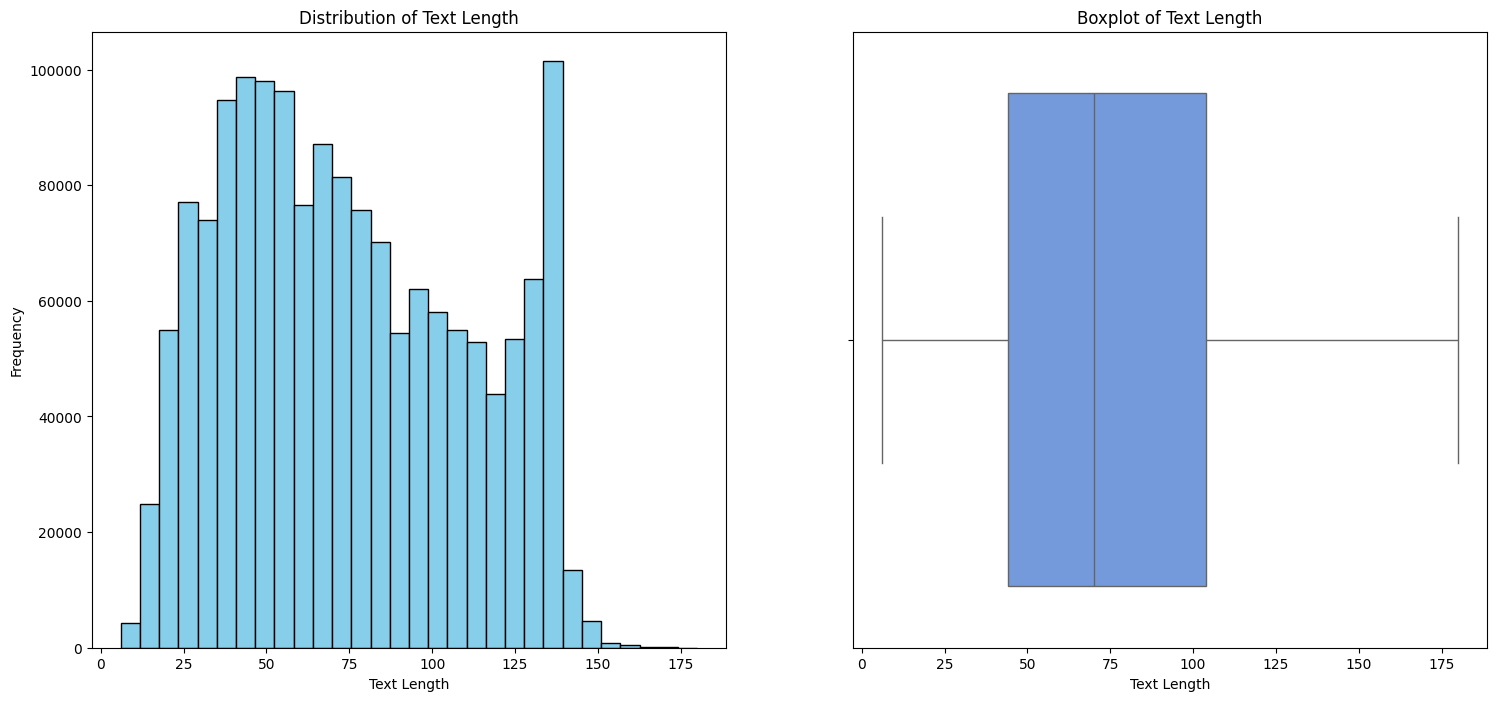

In [9]:
# Remove too long (outliers) text_length
df = df.filter(col("text_length") < 181)
df.select("text_length").describe().show()

# Visualize
text_length_pd = df.select("text_length").toPandas()

plt.figure(figsize=(18, 8))

plt.subplot(1,2,1)
plt.hist(text_length_pd["text_length"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.boxplot(x=text_length_pd["text_length"], color="cornflowerblue")
plt.title("Boxplot of Text Length")
plt.xlabel("Text Length")

+---------+-----------------+
|Sentiment| avg(text_length)|
+---------+-----------------+
|        1|74.19134374153501|
|        0|75.02407447104024|
+---------+-----------------+



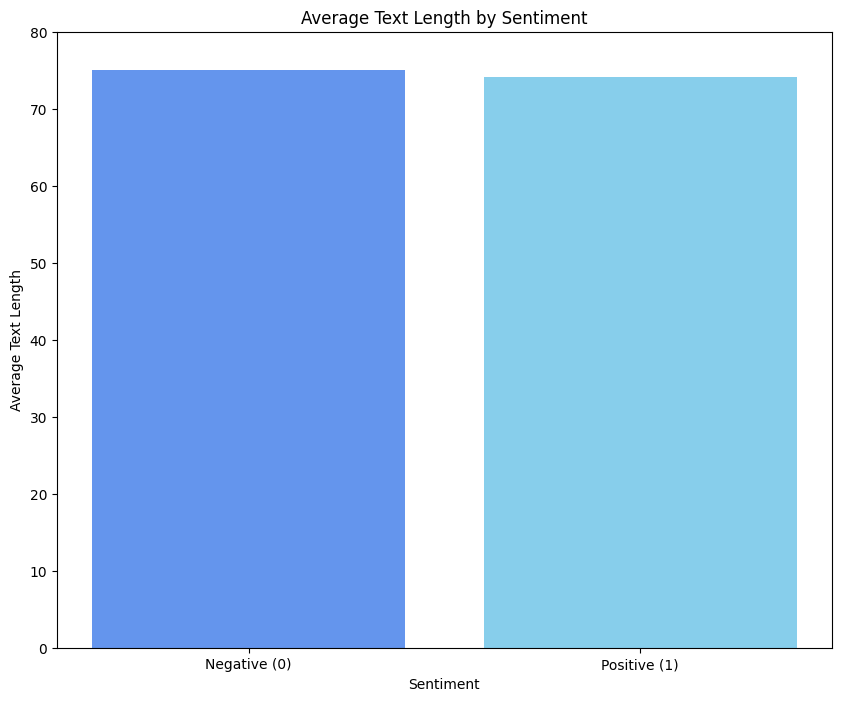

In [10]:
# Avg text length by sentiment
df.groupBy("Sentiment").avg("text_length").show()

avg_text_length = df.groupBy("Sentiment").avg("text_length").toPandas()

avg_text_length.columns = ["Sentiment", "Avg_Text_Length"]

plt.figure(figsize=(10, 8))
plt.bar(
    avg_text_length["Sentiment"], 
    avg_text_length["Avg_Text_Length"], 
    color=["skyblue", "cornflowerblue"]
)
plt.title("Average Text Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Text Length")
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])
plt.ylim(0, avg_text_length["Avg_Text_Length"].max() + 5)
plt.show()

In [11]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def normalize_text(df):
    # remove URL
    df = df.withColumn("SentimentText", F.regexp_replace("SentimentText", r"http\S+", ""))
    # remove username (with @)
    df = df.withColumn("SentimentText", F.regexp_replace("SentimentText", r"@[\w]+", ""))
    # remove hashtag (with #)
    df = df.withColumn("SentimentText", F.regexp_replace("SentimentText", r"#\w+", ""))
    # remove number and special character
    df = df.withColumn("SentimentText", F.regexp_replace("SentimentText", r"[^a-zA-Z\s]", ""))
    # Uppercase to Lowercase
    df = df.withColumn("SentimentText", F.lower("SentimentText"))
    # Remove space at start and end of sentences
    df = df.withColumn("SentimentText", F.trim("SentimentText"))
    return df

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

lemmatize_udf = udf(lemmatize_words, ArrayType(StringType()))

df = normalize_text(df)

tokenizer = Tokenizer(inputCol="SentimentText", outputCol="words")
df = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

df = df.withColumn("lemmatized_words", lemmatize_udf("filtered_words"))

word_counts = df.withColumn("word", F.explode("lemmatized_words")) \
                .groupBy("word", "Sentiment").count() \
                .orderBy("count", ascending=False)

min_frequency = 5
filtered_word_counts = word_counts.filter(word_counts['count'] >= min_frequency)

filtered_word_counts.show(10)

[nltk_data] Downloading package wordnet to /home/hungnd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


+----+---------+------+
|word|Sentiment| count|
+----+---------+------+
|    |        0|487812|
|    |        1|469714|
|  im|        0|102573|
|  im|        1| 74838|
|good|        1| 59608|
| day|        1| 53123|
| day|        0| 49756|
|love|        1| 49351|
| get|        0| 47726|
|  go|        0| 47165|
+----+---------+------+
only showing top 10 rows



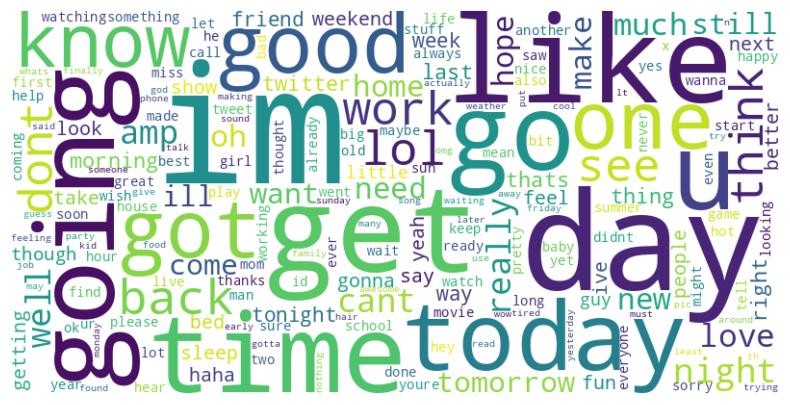

In [12]:
word_freq = {row['word']: row['count'] for row in filtered_word_counts.collect()}
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/tmp/ipykernel_7981/3643320244.py:4: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=word_counts_df.head(20), palette="Blues_d")


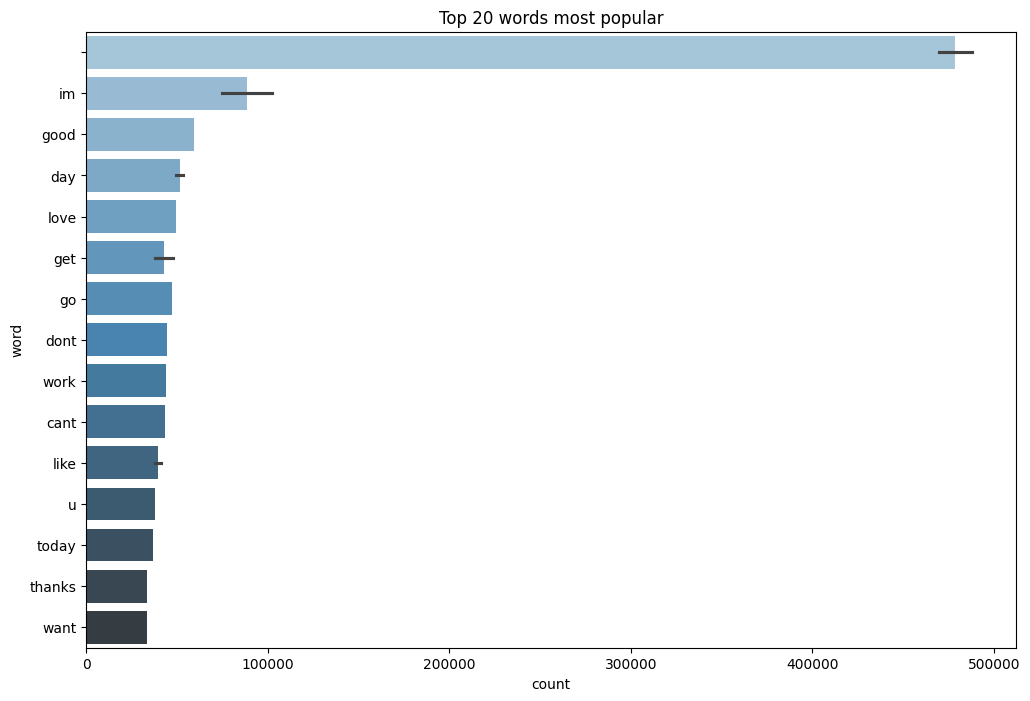

In [13]:
word_counts_df = word_counts.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="word", data=word_counts_df.head(20), palette="Blues_d")
plt.title("Top 20 words most popular")
plt.show()

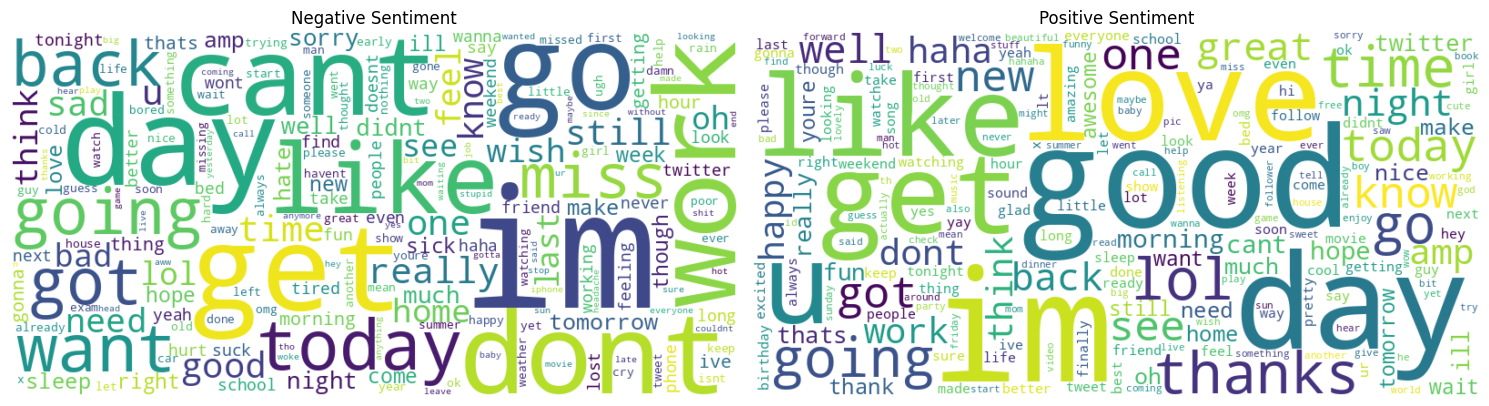

In [14]:
# negative
neg_data = filtered_word_counts.filter(filtered_word_counts["Sentiment"] == "0")
neg_word_freq = {row['word']: row['count'] for row in neg_data.collect()}

# positive
pos_data = filtered_word_counts.filter(filtered_word_counts["Sentiment"] == "1")
pos_word_freq = {row['word']: row['count'] for row in pos_data.collect()}

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

neg_wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(neg_word_freq)
axes[0].imshow(neg_wordcloud, interpolation="bilinear")
axes[0].set_title("Negative Sentiment")
axes[0].axis("off")

pos_wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(pos_word_freq)
axes[1].imshow(pos_wordcloud, interpolation="bilinear")
axes[1].set_title("Positive Sentiment")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [15]:
df.show()

+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|ItemID|Sentiment|SentimentSource|       SentimentText|text_length|               words|      filtered_words|    lemmatized_words|
+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|    62|        1|   Sentiment140|i always get what...|         27|[i, always, get, ...| [always, get, want]| [always, get, want]|
|   194|        1|   Sentiment140|tell  i said happ...|         44|[tell, , i, said,...|[tell, , said, ha...|[tell, , said, ha...|
|   436|        0|   Sentiment140|i hope everyone i...|        136|[i, hope, everyon...|[hope, everyone, ...|[hope, everyone, ...|
|   474|        0|   Sentiment140|all my friends ar...|        101|[all, my, friends...|[friends, gone, h...|[friend, gone, ha...|
|   619|        0|   Sentiment140|bcds closed i gue...|         36|[bcds, closed, i

In [17]:
df.repartition(7).write.format("parquet").save("hdfs://localhost:9000/final/cleaned_data")